#### Steps:

1. **Load Dataset:**

   * Reads the *Agaricus-Lepiota* mushroom dataset from `"mushroom/agaricus-lepiota.data"`.
   * Assigns proper column names for clarity.

2. **Prepare Features:**

   * Removes the target column (`class`) to iterate only over feature columns.

3. **Plot Count Distributions:**

   * For each categorical feature, creates a **count plot** using Seaborn.
   * The `hue='class'` parameter splits counts by mushroom type (`edible` vs `poisonous`).
   * Titles and labels are set dynamically for each feature.

#### Purpose:

To visualize how **feature values are distributed** between edible and poisonous mushrooms, allowing easy identification of distinguishing features such as `odor`, `gill-size`, or `spore-print-color`.


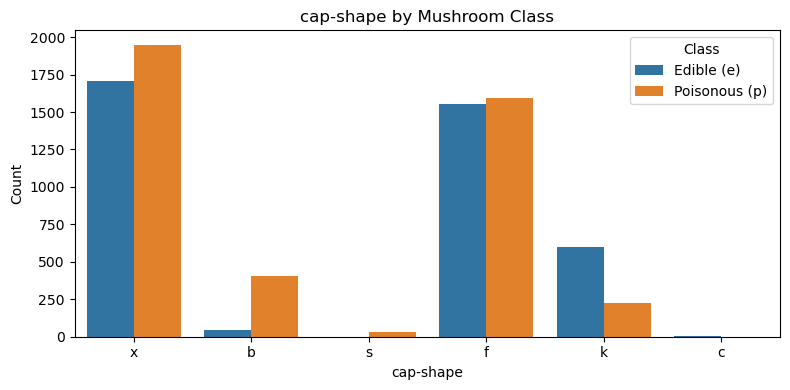

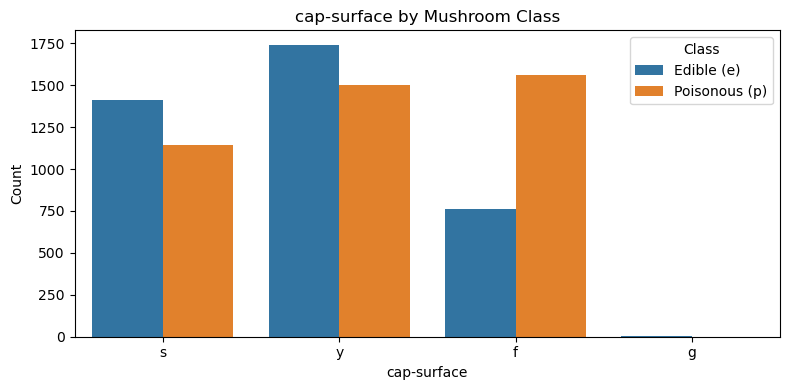

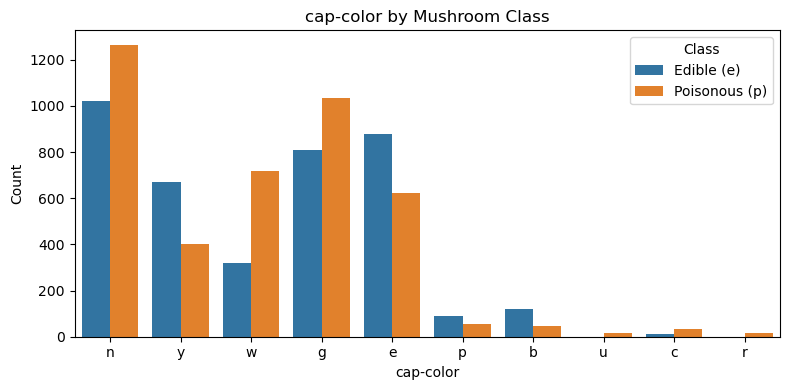

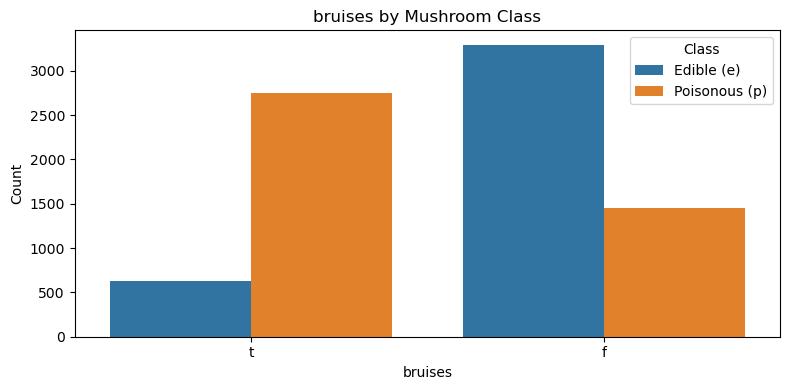

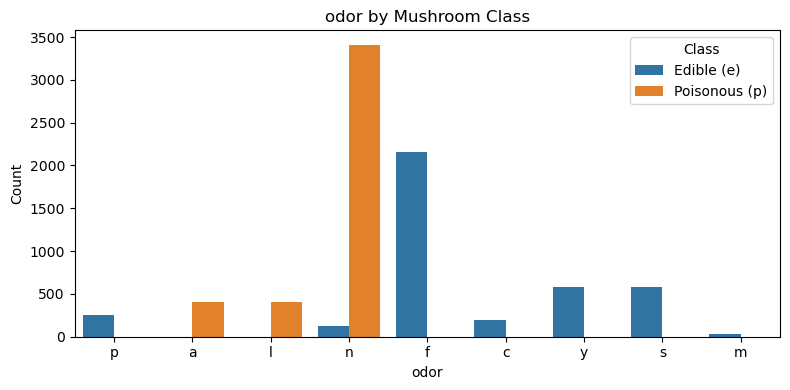

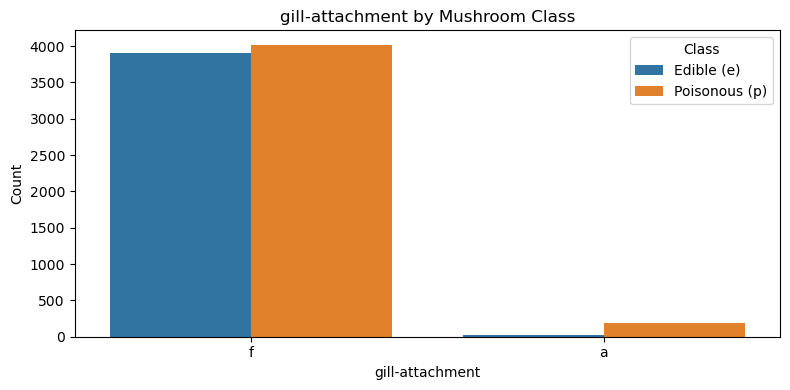

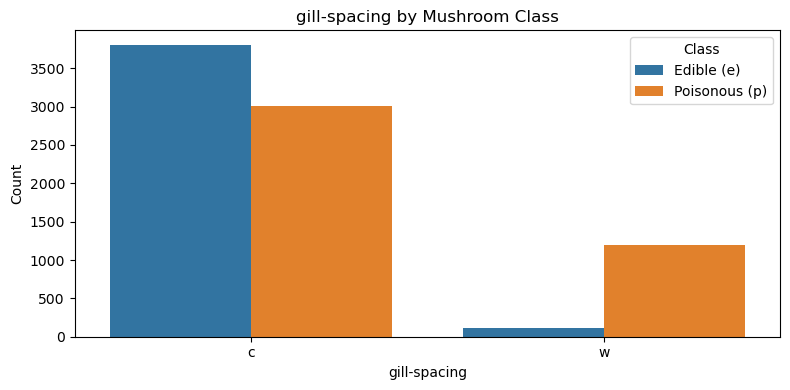

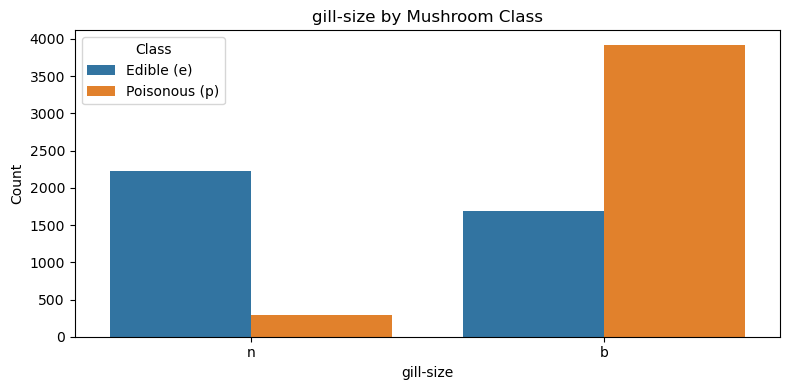

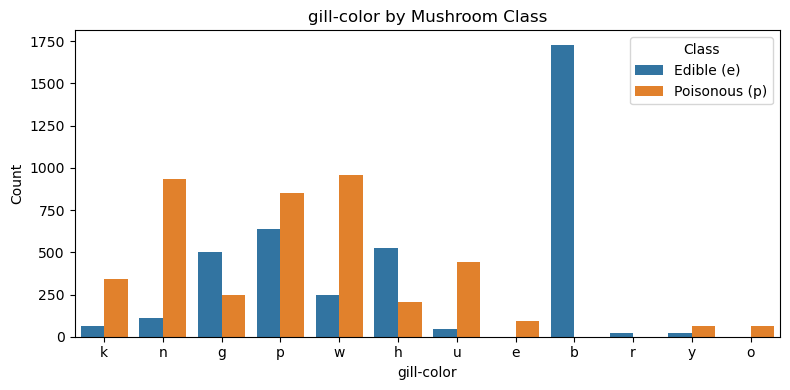

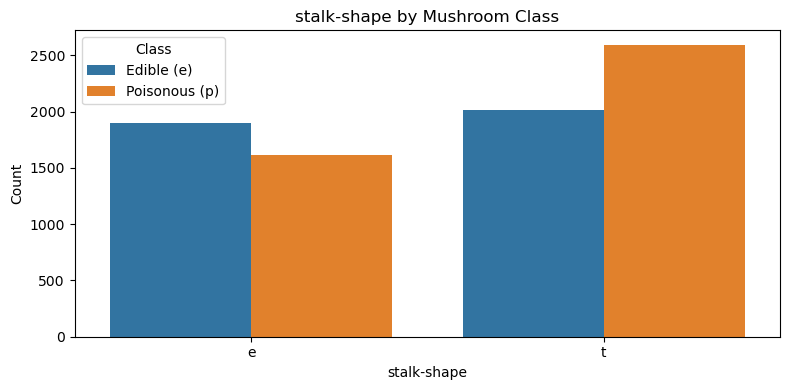

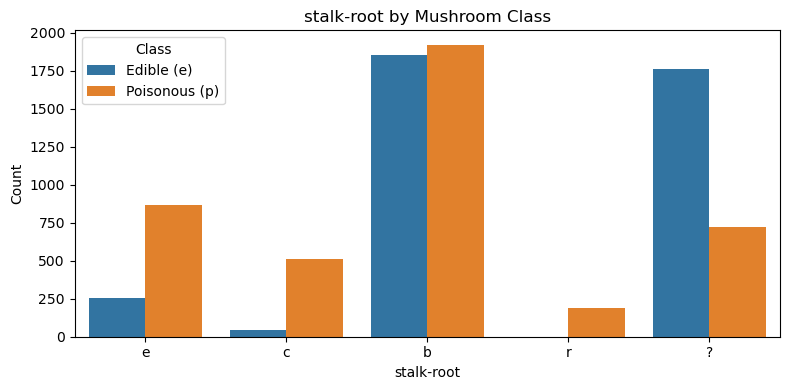

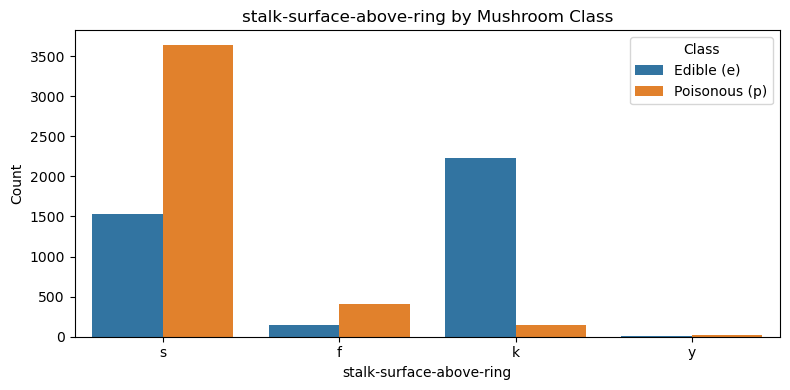

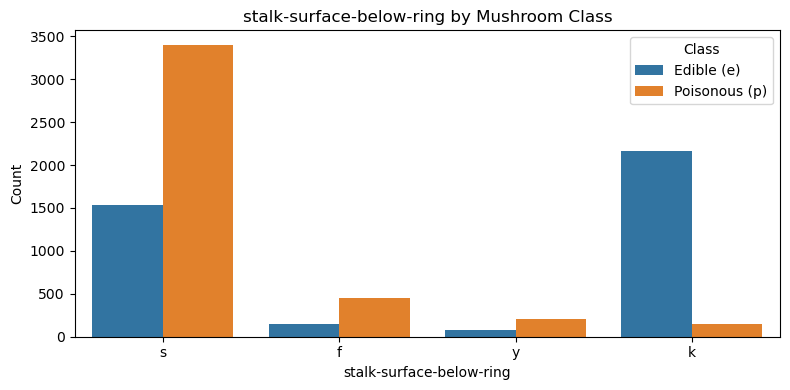

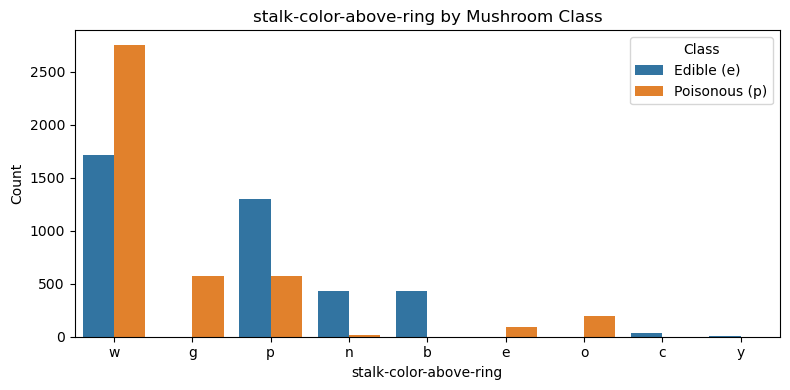

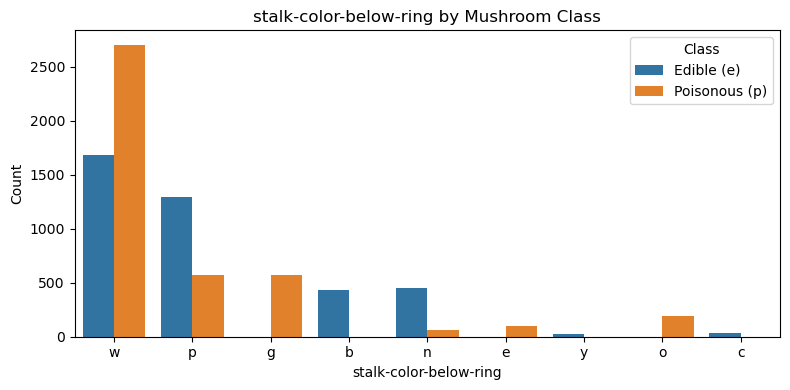

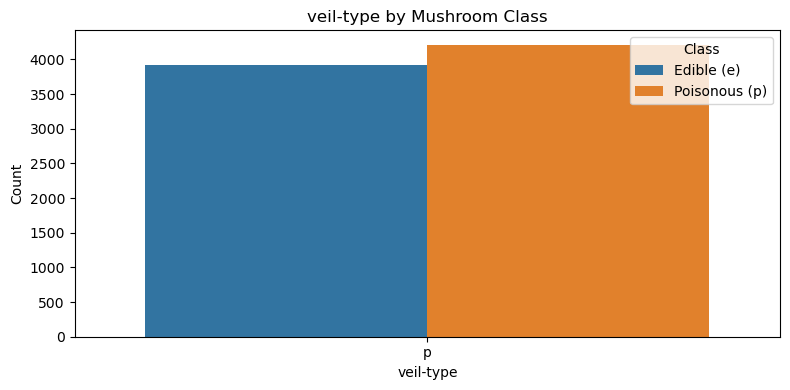

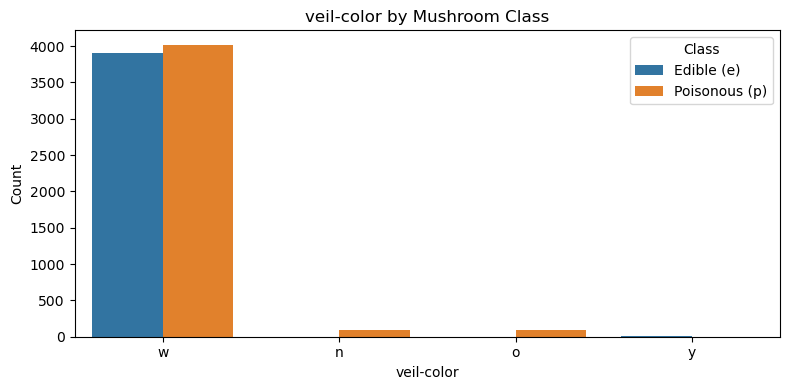

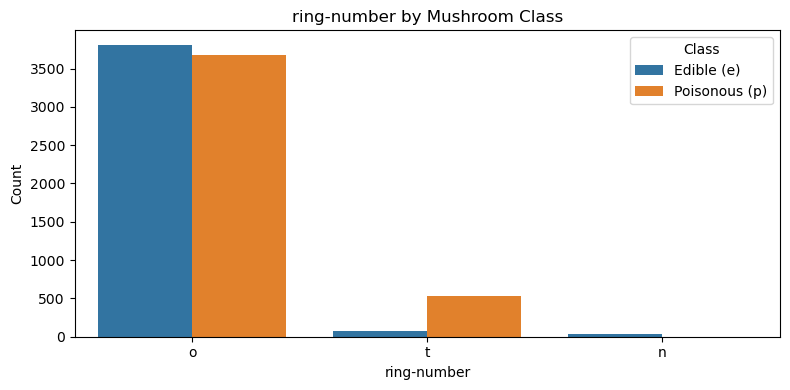

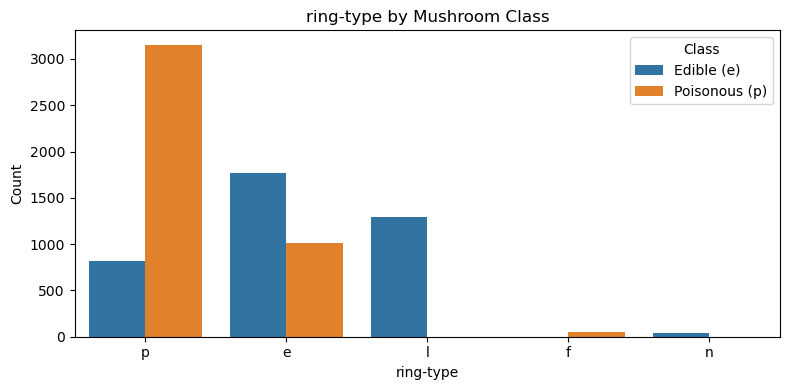

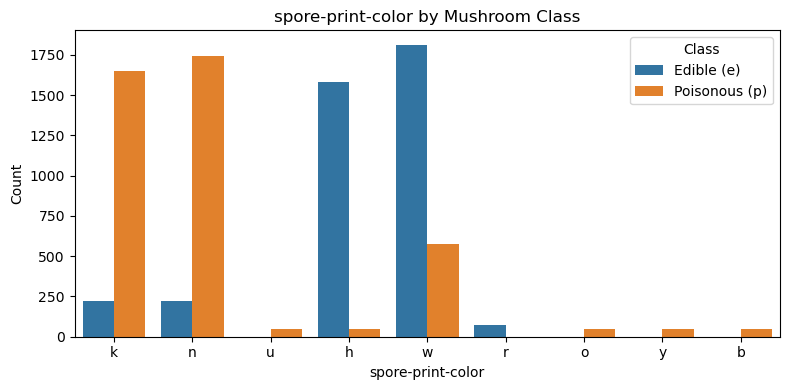

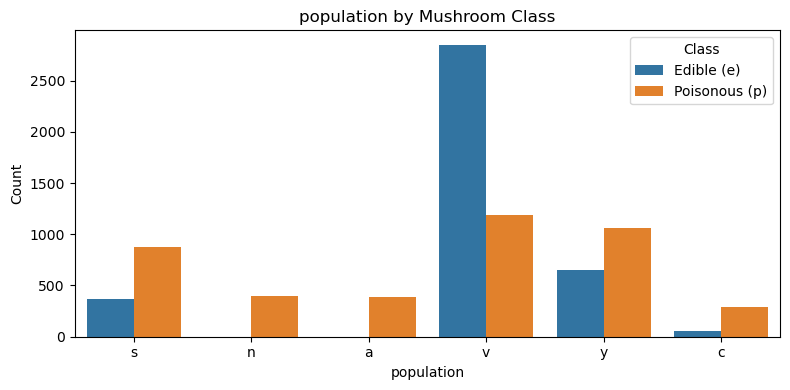

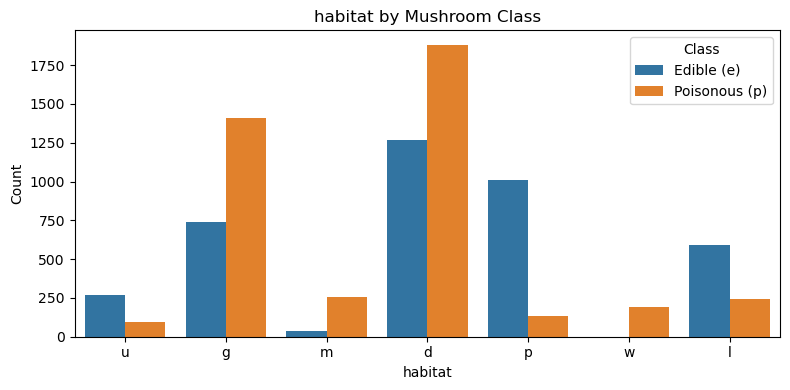

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

columns = [
    'class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor', 'gill-attachment',
    'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape', 'stalk-root',
    'stalk-surface-above-ring', 'stalk-surface-below-ring', 'stalk-color-above-ring',
    'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number', 'ring-type',
    'spore-print-color', 'population', 'habitat'
]

df = pd.read_csv("mushroom/agaricus-lepiota.data", header=None, names=columns)

features = [col for col in df.columns if col != 'class']

for feature in features:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, x=feature, hue='class')
    plt.title(f'{feature} by Mushroom Class')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.legend(title='Class', labels=['Edible (e)', 'Poisonous (p)'])
    plt.tight_layout()
    plt.show()


#### Steps:

1. **Data Preparation:**

   * Loads the mushroom dataset and splits it into features (`X`) and target (`y`).
   * Performs an 80–20 train–test split with `random_state=42` for reproducibility.

2. **Custom Class Definition (`NaiveBayesLaplace`):**

   * Implements a **categorical Naïve Bayes** model with **Laplace smoothing (α)**.
   * `fit()`:

     * Calculates **class priors** (`P(class)`).
     * For each feature, computes **conditional probabilities** (`P(feature=value | class)`) using Laplace correction.
   * `predict_one()`:

     * Computes **log posterior probabilities** for a single sample.
     * Selects the class with the highest posterior.
   * `predict()`:

     * Applies `predict_one()` across all rows in the dataset.

3. **Model Evaluation:**

   * Trains models for various Laplace smoothing values (`α = [0.0001, 0.001, 0.01, 0.1, 1, 10]`).
   * Prints accuracy for each α to analyze the impact of smoothing on model performance.

#### Purpose:

To demonstrate a **manual implementation of Naïve Bayes** for categorical data and show how **Laplace smoothing (α)** affects classification accuracy, particularly when handling unseen feature values.


In [3]:
from sklearn.model_selection import train_test_split
import numpy as np

X = df.drop('class', axis=1)
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

class NaiveBayesLaplace:
    def __init__(self, alpha=1.0):
        self.alpha = alpha

    def fit(self, X, y):
        self.classes = np.unique(y)
        self.priors = {c: np.log((y == c).mean()) for c in self.classes}
        self.likelihoods = {}
        for c in self.classes:
            X_c = X[y == c]
            self.likelihoods[c] = {}
            for col in X.columns:
                value_counts = X_c[col].value_counts()
                n_values = X[col].nunique()
                total = len(X_c)
                probs = {
                    v: (value_counts.get(v, 0) + self.alpha) / (total + n_values * self.alpha)
                    for v in X[col].unique()
                }
                self.likelihoods[c][col] = probs

    def predict_one(self, x):
        posteriors = {}
        for c in self.classes:
            log_prob = self.priors[c]
            for feature, value in x.items():
                likelihood = self.likelihoods[c][feature].get(value, self.alpha / (self.alpha * len(self.likelihoods[c][feature])))
                log_prob += np.log(likelihood)
            posteriors[c] = log_prob
        return max(posteriors, key=posteriors.get)

    def predict(self, X):
        return X.apply(self.predict_one, axis=1)

alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10]
for a in alphas:
    model = NaiveBayesLaplace(alpha=a)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = (y_pred == y_test).mean()
    print(f"Alpha = {a:.4f}, Accuracy = {accuracy:.4f}")


Alpha = 0.0001, Accuracy = 0.9951
Alpha = 0.0010, Accuracy = 0.9932
Alpha = 0.0100, Accuracy = 0.9914
Alpha = 0.1000, Accuracy = 0.9809
Alpha = 1.0000, Accuracy = 0.9508
Alpha = 10.0000, Accuracy = 0.9280


#### Steps:

1. **Iterate Over Different α Values:**

   * Loops through each Laplace smoothing value in `alphas`.
   * Trains the `NaiveBayesLaplace` model on the training set.

2. **Compute Accuracy:**

   * Predicts on both training and testing data.
   * Calculates and stores train and test accuracy for each α.

3. **Store and Analyze Results:**

   * Saves all results (α, train accuracy, test accuracy) into a DataFrame `res_df`.
   * Finds the best α value by selecting the one with the highest test accuracy.

#### Purpose:

To identify the **optimal Laplace smoothing parameter (α)** that balances bias and variance, achieving the best generalization performance for the Naïve Bayes classifier.


In [4]:
# Store results for all alphas
results = []

for a in alphas:
    model = NaiveBayesLaplace(alpha=a)
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    results.append({
        'alpha': a,
        'train_acc': (y_pred_train == y_train).mean(),
        'test_acc': (y_pred_test == y_test).mean()
    })

import pandas as pd
res_df = pd.DataFrame(results)
best_alpha = res_df.loc[res_df['test_acc'].idxmax(), 'alpha']
print("Best alpha:", best_alpha)


Best alpha: 0.0001


#### Steps:

1. **Train Final Model:**

   * Re-trains `NaiveBayesLaplace` using the optimal Laplace smoothing parameter (`best_alpha`).

2. **Generate Predictions:**

   * Predicts class labels on both the **training** and **testing** datasets.

3. **Compute Confusion Matrices:**

   * Uses `confusion_matrix()` from scikit-learn to compare actual vs predicted labels for both sets.

4. **Visualize Results:**

   * Plots two side-by-side **heatmaps** (training and testing) using Seaborn.
   * Displays class counts and titles indicating the smoothing parameter used.

#### Purpose:

To evaluate and visually compare **model performance** on the training and testing data.
The confusion matrices help identify how well the model distinguishes between edible and poisonous mushrooms, revealing any class imbalance or misclassification trends.


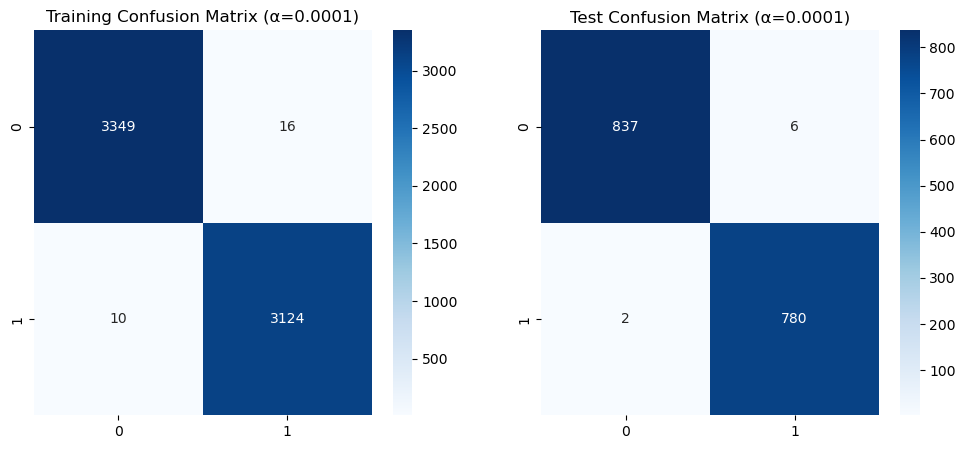

In [5]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

best_model = NaiveBayesLaplace(alpha=best_alpha)
best_model.fit(X_train, y_train)
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title(f'Training Confusion Matrix (α={best_alpha})')
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title(f'Test Confusion Matrix (α={best_alpha})')
plt.show()

#### Steps:

1. **Iterate Over α Values:**

   * Trains the `NaiveBayesLaplace` model for each Laplace smoothing parameter in `alphas`.

2. **Model Evaluation:**

   * Predicts labels for both **training** and **testing** sets.
   * Computes the following metrics using scikit-learn:

     * **Accuracy** – overall correctness of predictions.
     * **Precision** – proportion of correctly predicted poisonous mushrooms (`pos_label='p'`).
     * **Recall** – how well the model detects poisonous mushrooms.
     * **F1 Score** – harmonic mean of precision and recall.

3. **Store Results:**

   * Saves all computed metrics for each α into a DataFrame `res_df`.
   * Allows easy comparison of performance trends across different smoothing values.

#### Purpose:

To evaluate the **impact of Laplace smoothing (α)** on model performance using detailed classification metrics (accuracy, precision, recall, F1).

In [6]:
from sklearn.metrics import precision_score, recall_score, f1_score

results = []
for a in alphas:
    model = NaiveBayesLaplace(alpha=a)
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    results.append({
        'alpha': a,
        'train_acc': (y_pred_train == y_train).mean(),
        'test_acc': (y_pred_test == y_test).mean(),
        'train_prec': precision_score(y_train, y_pred_train, pos_label='p'),
        'test_prec': precision_score(y_test, y_pred_test, pos_label='p'),
        'train_rec': recall_score(y_train, y_pred_train, pos_label='p'),
        'test_rec': recall_score(y_test, y_pred_test, pos_label='p'),
        'train_f1': f1_score(y_train, y_pred_train, pos_label='p'),
        'test_f1': f1_score(y_test, y_pred_test, pos_label='p')
    })

res_df = pd.DataFrame(results)
print(res_df)


     alpha  train_acc  test_acc  train_prec  test_prec  train_rec  test_rec  \
0   0.0001   0.995999  0.995077    0.994904   0.992366   0.996809  0.997442   
1   0.0010   0.992614  0.993231    0.994869   0.992337   0.989789  0.993606   
2   0.0100   0.990922  0.991385    0.994850   0.992308   0.986280  0.989770   
3   0.1000   0.980766  0.980923    0.994739   0.992136   0.965220  0.968031   
4   1.0000   0.955378  0.950769    0.993750   0.991597   0.913210  0.905371   
5  10.0000   0.933374  0.928000    0.987721   0.982583   0.872687  0.865729   

   train_f1   test_f1  
0  0.995856  0.994898  
1  0.992322  0.992971  
2  0.990546  0.991037  
3  0.979757  0.979935  
4  0.951779  0.946524  
5  0.926647  0.920462  


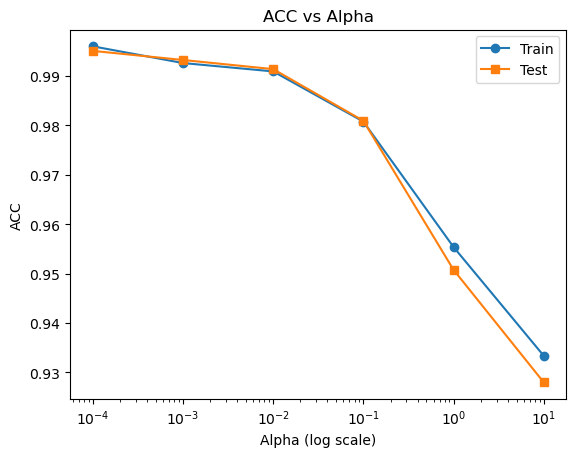

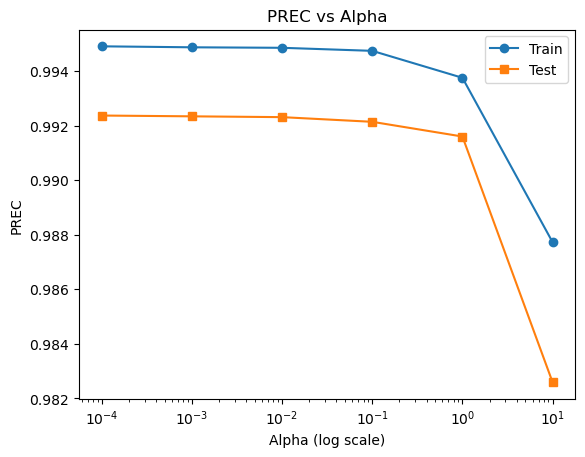

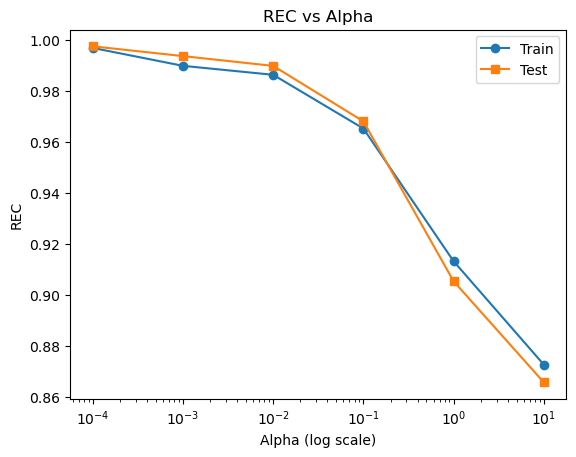

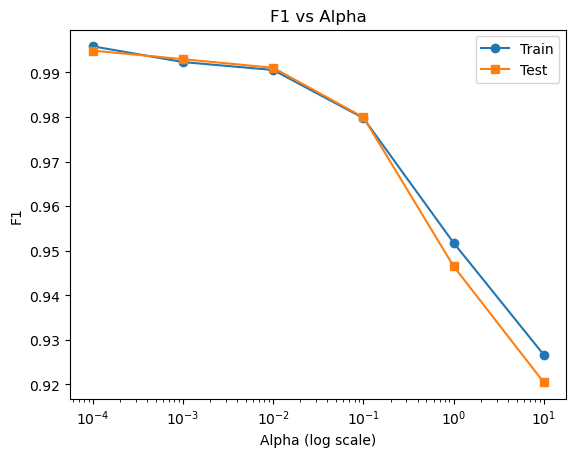

In [7]:
metrics = ['acc', 'prec', 'rec', 'f1']
for m in metrics:
    plt.figure()
    plt.xscale('log')
    plt.plot(res_df['alpha'], res_df[f'train_{m}'], marker='o', label='Train')
    plt.plot(res_df['alpha'], res_df[f'test_{m}'], marker='s', label='Test')
    plt.title(f'{m.upper()} vs Alpha')
    plt.xlabel('Alpha (log scale)')
    plt.ylabel(m.upper())
    plt.legend()
    plt.show()


#### Steps:

1. **Feature Duplication Setup:**

   * Selects a categorical feature (`odor`) to duplicate.
   * Creates new datasets by adding 1–4 duplicate copies of this feature to both training and testing sets.

2. **Model Training and Evaluation:**

   * Trains the `NaiveBayesLaplace` model (with the best `alpha`) on each modified dataset.
   * Calculates **training** and **testing accuracy** for each version.

3. **Visualization:**

   * Plots accuracy versus the number of duplicated features to observe performance changes.
   * Also outputs a DataFrame summarizing train and test accuracies for 0–4 copies.

#### Purpose:

To demonstrate how **feature redundancy** affects Naïve Bayes classification.

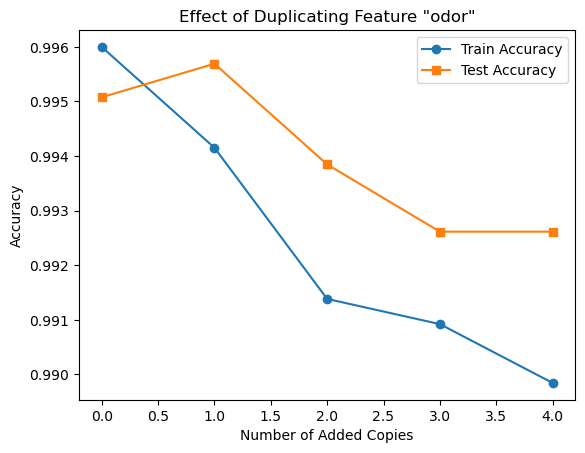

,Copies,Train Accuracy,Test Accuracy
0,0,0.995999,0.995077
1,1,0.994153,0.995692
2,2,0.991383,0.993846
3,3,0.990922,0.992615
4,4,0.989845,0.992615


In [8]:
feature_to_duplicate = 'odor'
datasets = [(X_train.copy(), X_test.copy())]
for i in range(1, 5):
    X_train_dup = X_train.copy()
    X_test_dup = X_test.copy()
    for j in range(i):
        X_train_dup[f'{feature_to_duplicate}_copy{j+1}'] = X_train[feature_to_duplicate]
        X_test_dup[f'{feature_to_duplicate}_copy{j+1}'] = X_test[feature_to_duplicate]
    datasets.append((X_train_dup, X_test_dup))

train_accs, test_accs = [], []
for X_tr, X_te in datasets:
    model = NaiveBayesLaplace(alpha=best_alpha)
    model.fit(X_tr, y_train)
    y_pred_train = model.predict(X_tr)
    y_pred_test = model.predict(X_te)
    train_accs.append((y_pred_train == y_train).mean())
    test_accs.append((y_pred_test == y_test).mean())

copies = [0, 1, 2, 3, 4]
plt.plot(copies, train_accs, marker='o', label='Train Accuracy')
plt.plot(copies, test_accs, marker='s', label='Test Accuracy')
plt.title(f'Effect of Duplicating Feature \"{feature_to_duplicate}\"')
plt.xlabel('Number of Added Copies')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

pd.DataFrame({'Copies': copies, 'Train Accuracy': train_accs, 'Test Accuracy': test_accs})
